In [9]:
import math
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

In [10]:
experiment = "split_20231212"

In [11]:
def open_df(data,experiment=experiment):
    df = pd.read_csv(experiment + "/Automation_out/"+data+"_spots.csv",encoding='cp1252')
    df = df[3:]
    df = df.astype({
            "ID" : int,
            "TRACK_ID" : int, 
            "POSITION_X" : float,
            "POSITION_Y" : float,
            "POSITION_Z" : float,
            "POSITION_T" : float,
            "FRAME" : int,
            "MIN_INTENSITY_CH1" : float,
            "MAX_INTENSITY_CH1" : float,
            "MEDIAN_INTENSITY_CH1" : float,
            "TOTAL_INTENSITY_CH1" : float,
            "STD_INTENSITY_CH1" : float,
            "CONTRAST_CH1" : float,
            "SNR_CH1" : float
            })
    return df

def get_x_data(df,T,zmin=0.0,zmax=100.0):
    return df[(df["FRAME"]==T) & (df["POSITION_Z"]>=zmin) & (df["POSITION_Z"]<=zmax)]["POSITION_X"].to_numpy()
def get_y_data(df,T,zmin=0.0,zmax=100.0):
    return df[(df["FRAME"]==T) & (df["POSITION_Z"]>=zmin) & (df["POSITION_Z"]<=zmax)]["POSITION_Y"].to_numpy()
def get_snr(df,T,zmin=0.0,zmax=100.0):
    return df[(df["FRAME"]==T) & (df["POSITION_Z"]>=zmin) & (df["POSITION_Z"]<=zmax)]["SNR_CH1"].to_numpy()
def get_intensity(df,T,zmin=0.0,zmax=100.0):
    log_intensity = np.log10(df[(df["FRAME"]==T) & (df["POSITION_Z"]>=zmin) & (df["POSITION_Z"]<=zmax)]["TOTAL_INTENSITY_CH1"].to_numpy())
    log_intensity -= log_intensity.min()
    log_intensity *= 0.9/log_intensity.max()
    log_intensity += 0.09
    return log_intensity
    

In [12]:
%matplotlib widget
from matplotlib.widgets import Button, Slider

def df_to_timeplot(data,alpha_prox=1.0,alpha_dist=1.0,dz=100.0,z=0.0):
    df_prox = open_df(data + "_Proximal")
    df_dist = open_df(data + "_Distal")
    fig, ax = plt.subplots()
    T=1
    # snr_prox = np.minimum(1.0,10 ** (get_snr(df_prox,T)/10))
    # snr_dist = np.minimum(1.0,10 ** (get_snr(df_dist,T)/10))
    op_prox = get_intensity(df_prox,T,zmin=z-dz,zmax=z+dz)
    op_dist = get_intensity(df_dist,T,zmin=z-dz,zmax=z+dz)
    scat_prox = ax.scatter(get_x_data(df_prox,T,zmin=z-dz,zmax=z+dz),get_y_data(df_prox,T,zmin=z-dz,zmax=z+dz),s=10.0,c="m",alpha=alpha_prox*op_prox)
    scat_dist = ax.scatter(get_x_data(df_dist,T,zmin=z-dz,zmax=z+dz),get_y_data(df_dist,T,zmin=z-dz,zmax=z+dz),s=10.0,c="g",alpha=alpha_dist*op_dist)
    ax.set_xlim(0.0,df_dist["POSITION_X"].max())
    ax.set_ylim(0.0,df_dist["POSITION_X"].max())
    ax.invert_yaxis()
    ax.set_aspect("equal")
    fig.subplots_adjust(left=0.25, bottom=0.25)

    axtime = fig.add_axes([0.25, 0.1, 0.65, 0.03])
    frame_slider = Slider(
        ax=axtime,
        label='FRAME',
        valmin=1,
        valmax=min(df_dist["FRAME"].max(),df_prox["FRAME"].max()),
        valinit=1,
        valstep=1
    )
    
    axamp_prox = fig.add_axes([0.1, 0.25, 0.0225, 0.63])
    axamp_prox_slider = Slider(
        ax=axamp_prox,
        label="Proximal",
        valmin=0,
        valmax=1,
        valinit=1.0,
        orientation="vertical"
    )
    
    axamp_dist = fig.add_axes([0.95, 0.25, 0.0225, 0.63])
    axamp_dist_slider = Slider(
        ax=axamp_dist,
        label="Distal",
        valmin=0,
        valmax=1,
        valinit=1.0,
        orientation="vertical"
    )
    
    axz = fig.add_axes([0.25, 0.95, 0.65, 0.03])
    z_slider = Slider(
        ax=axz,
        label='Z',
        valmin=0.0,
        valmax=df_dist["POSITION_Z"].max(),
        valinit=0.0,
    )

    def update(val):
        scat_prox.set_offsets(np.c_[get_x_data(df_prox,frame_slider.val),get_y_data(df_prox,frame_slider.val)])
        scat_dist.set_offsets(np.c_[get_x_data(df_dist,frame_slider.val),get_y_data(df_dist,frame_slider.val)])
        # snr_prox = np.minimum(1.0,10 ** (get_snr(df_prox,frame_slider.val)/10))
        # snr_dist = np.minimum(1.0,10 ** (get_snr(df_dist,frame_slider.val)/10))
        op_prox = get_intensity(df_prox,frame_slider.val,zmin=z_slider.val-dz,zmax=z_slider.val+dz)
        op_dist = get_intensity(df_dist,frame_slider.val,zmin=z_slider.val-dz,zmax=z_slider.val+dz)
        scat_prox.set_alpha(axamp_prox_slider.val * op_prox)
        scat_dist.set_alpha(axamp_dist_slider.val * op_dist)
        fig.canvas.draw_idle()
    
    def update_alpha_prox(val):
        # scat_prox.set_alpha(axamp_prox_slider.val)
        op_prox = get_intensity(df_prox,frame_slider.val,zmin=z_slider.val-dz,zmax=z_slider.val+dz)
        scat_prox.set_alpha(axamp_prox_slider.val * op_prox)
        fig.canvas.draw_idle()

    def update_alpha_dist(val):
        # scat_dist.set_alpha(axamp_dist_slider.val)
        op_dist = get_intensity(df_dist,frame_slider.val,zmin=z_slider.val-dz,zmax=z_slider.val+dz)
        scat_dist.set_alpha(axamp_dist_slider.val * op_dist)
        fig.canvas.draw_idle()
        
    def update_z(val):
        scat_prox.set_offsets(np.c_[get_x_data(df_prox,frame_slider.val,zmin=z_slider.val-dz,zmax=z_slider.val+dz),get_y_data(df_prox,frame_slider.val,zmin=z_slider.val-dz,zmax=z_slider.val+dz)])
        scat_dist.set_offsets(np.c_[get_x_data(df_dist,frame_slider.val,zmin=z_slider.val-dz,zmax=z_slider.val+dz),get_y_data(df_dist,frame_slider.val,zmin=z_slider.val-dz,zmax=z_slider.val+dz)])
        op_prox = get_intensity(df_prox,frame_slider.val,zmin=z_slider.val-dz,zmax=z_slider.val+dz)
        op_dist = get_intensity(df_dist,frame_slider.val,zmin=z_slider.val-dz,zmax=z_slider.val+dz)
        scat_prox.set_alpha(axamp_prox_slider.val * op_prox)
        scat_dist.set_alpha(axamp_dist_slider.val * op_dist)
        fig.canvas.draw_idle()
        
    frame_slider.on_changed(update)
    axamp_prox_slider.on_changed(update_alpha_prox)
    axamp_dist_slider.on_changed(update_alpha_dist)
    z_slider.on_changed(update_z)

    resetax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
    button = Button(resetax, 'Reset', hovercolor='0.975')

    def reset(event):
        frame_slider.reset()
        axamp_prox_slider.reset()
        axamp_dist_slider.reset()
    button.on_clicked(reset)
    
    return fig, ax, scat_prox, scat_dist

def df_to_lastplot(data):
    df_prox = open_df(data + "_Proximal")
    df_dist = open_df(data + "_Distal")
    fig, ax = plt.subplots()
    T=min(df_prox["FRAME"].max(),df_dist["FRAME"].max())
    scat_prox = ax.scatter(get_x_data(df_prox,T),get_y_data(df_prox,T),s=10.0,c="blueviolet")
    scat_dist = ax.scatter(get_x_data(df_dist,T),get_y_data(df_dist,T),s=10.0,c="forestgreen")
    ax.set_xlim(0.0,df_dist["POSITION_X"].max())
    ax.set_ylim(0.0,df_dist["POSITION_X"].max())
    ax.set_aspect("equal")
    return fig, ax, scat_prox, scat_dist

/var/folders/q_/7gz310cd4n1_v1xcnv2_qdbm0000gn/T/ipykernel_9787/1480289293.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(experiment + "/Automation_out/"+data+"_spots.csv",encoding='cp1252')
/var/folders/q_/7gz310cd4n1_v1xcnv2_qdbm0000gn/T/ipykernel_9787/1480289293.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(experiment + "/Automation_out/"+data+"_spots.csv",encoding='cp1252')


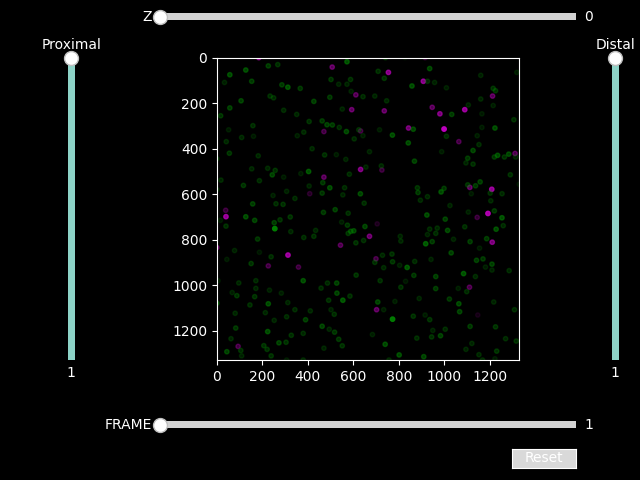

In [17]:
plt.style.use('dark_background')
fig_slider, ax_slider, scat_prox_slider, scat_dist_slider = df_to_timeplot("FWF003",dz=100.0)

In [14]:
def plot_all_last():
    for k in range(9):
        data = "FWF00" + str(k+1)
        fig_last, ax_last, scat_prox_last, scat_dist_last = df_to_lastplot(data)
        ax_last.set_title(data)

In [15]:
# plot_all_last()

In [16]:
len(get_x_data(open_df("FWF006" + "_Proximal"),287,zmin=0,zmax=1000))

/var/folders/q_/7gz310cd4n1_v1xcnv2_qdbm0000gn/T/ipykernel_9787/1480289293.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(experiment + "/Automation_out/"+data+"_spots.csv",encoding='cp1252')


1071